In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
%matplotlib inline

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('NYC311data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300698 entries, 0 to 300697
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unique Key                      300698 non-null  int64  
 1   Created Date                    300698 non-null  object 
 2   Closed Date                     298534 non-null  object 
 3   Agency                          300698 non-null  object 
 4   Agency Name                     300698 non-null  object 
 5   Complaint Type                  300698 non-null  object 
 6   Descriptor                      294784 non-null  object 
 7   Location Type                   300567 non-null  object 
 8   Incident Zip                    298083 non-null  float64
 9   Incident Address                256288 non-null  object 
 10  Street Name                     256288 non-null  object 
 11  Cross Street 1                  251419 non-null  object 
 12  Cross Street 2  

# Data Exploration

In [3]:
# Importing warnings module and re-running the function for continuous feature report
import warnings

# Re-defining the function to build a report for continuous features
def continuous_features_report(data_df):
    # Stats we wish to calculate
    stats = {
        "Count": len, #count of items
        "Miss %": lambda df: df.isna().sum() / len(df) * 100, #percentage of missing values
        "Card.": lambda df: df.nunique(), #cardinal values
        "Min": lambda df: df.min(), #minimum value
        "1st Qrt.": lambda df: df.quantile(0.25), #1st quartile value
        "Mean": lambda df: df.mean(), #mean value
        "Median": lambda df: df.median(), #median value
        "3rd Qrt": lambda df: df.quantile(0.75), #3rd quartile value
        "Max": lambda df: df.max(), #max value
        "Std. Dev.": lambda df: df.std(), #standard deviation
    }
    
    # Select the columns with numerical datatypes
    continuous_feat_names = data_df.select_dtypes("number").columns
    continuous_data_df = data_df[continuous_feat_names]

    # Initialize report DataFrame
    report_df = pd.DataFrame(index=continuous_feat_names, columns=stats.keys())

    # Calculate stats for each feature
    for stat_name, fn in stats.items():
        # Ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = continuous_data_df.apply(fn)

    return report_df

# Generating the report for continuous features in the ABT
continuous_report = continuous_features_report(df)
continuous_report


,Count,Miss %,Card.,Min,1st Qrt.,Mean,Median,3rd Qrt,Max,Std. Dev.
Unique Key,300698,0.000000,300698,3.027948e+07,3.080118e+07,3.130054e+07,3.130436e+07,3.178446e+07,3.231065e+07,573854.692971
Incident Zip,300698,0.869643,201,8.300000e+01,1.031000e+04,1.084889e+04,1.120800e+04,1.123800e+04,1.169700e+04,583.182081
X Coordinate (State Plane),300698,1.177261,63226,9.133570e+05,9.919752e+05,1.004854e+06,1.003158e+06,1.018372e+06,1.067173e+06,21753.384466
Y Coordinate (State Plane),300698,1.177261,73694,1.212190e+05,1.833430e+05,2.037545e+05,2.011105e+05,2.241252e+05,2.718760e+05,29880.183529
School or Citywide Complaint,300698,100.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle Type,300698,100.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Taxi Company Borough,300698,100.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Taxi Pick Up Location,300698,100.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Garage Lot Name,300698,100.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,300698,1.177261,125122,4.049913e+01,4.066980e+01,4.072588e+01,4.071866e+01,4.078184e+01,4.091287e+01,0.082012


In [4]:
# Correcting the function to build a report for categorical features
def categorical_features_report(data_df):
    # Define the statistics to calculate
    def _mode(df):
        return df.mode().iloc[0]

    def _mode_freq(df):
        mode_val = _mode(df)
        return (df == mode_val).sum()

    def _second_mode(df):
        mode_val = _mode(df)
        second_mode_series = df[df != mode_val].mode()
        return second_mode_series.iloc[0] if not second_mode_series.empty else None

    def _second_mode_freq(df):
        second_mode_val = _second_mode(df)
        return (df == second_mode_val).sum() if second_mode_val is not None else 0

    stats = {
        "Count": len,  # count of items
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,  # percentage of missing values
        "Card.": lambda df: df.nunique(),  # cardinal values
        "Mode": _mode,  # mode
        "Mode Freq": _mode_freq,  # mode frequency
        "Mode %": lambda df: _mode_freq(df) / len(df) * 100,  # percentage of mode values in dataset
        "2nd Mode": _second_mode,  # second mode
        "2nd Mode Freq": _second_mode_freq,  # second mode frequency
        "2nd Mode %": lambda df: _second_mode_freq(df) / len(df) * 100,  # percentage of second mode values in dataset
    }

    # Select the columns with non-numerical datatypes
    categorical_feat_names = data_df.select_dtypes(exclude="number").columns
    categorical_data_df = data_df[categorical_feat_names]

    # Initialize report DataFrame
    report_df = pd.DataFrame(index=categorical_feat_names, columns=stats.keys())

    # Calculate stats for each feature
    for stat_name, fn in stats.items():
        # Ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(categorical_data_df)

    return report_df

# Generating the report for categorical features in the ABT
categorical_report = categorical_features_report(df)
categorical_report


,Count,Miss %,Card.,Mode,Mode Freq,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %
Created Date,300698,0.000000,259493,06-06-15 22:23,9,0.002993,07-11-15 23:04,9,0.002993
Closed Date,300698,0.719659,237165,11-08-15 7:34,24,0.007981,10-11-15 7:03,22,0.007316
Agency,300698,0.000000,1,NYPD,300698,100.000000,NaN,0,0.000000
Agency Name,300698,0.000000,3,New York City Police Department,300690,99.997340,Internal Affairs Bureau,6,0.001995
Complaint Type,300698,0.000000,24,Blocked Driveway,77044,25.621720,Illegal Parking,75361,25.062022
Descriptor,300698,1.966757,45,Loud Music/Party,61430,20.429135,No Access,56976,18.947915
Location Type,300698,0.043565,18,Street/Sidewalk,249299,82.906770,Store/Commercial,20381,6.777897
Incident Address,300698,14.768971,107652,1207 BEACH AVENUE,904,0.300634,78-15 PARSONS BOULEVARD,505,0.167943
Street Name,300698,14.768971,7320,BROADWAY,3237,1.076495,3 AVENUE,1241,0.412706
Cross Street 1,300698,16.388203,5982,BROADWAY,4338,1.442643,BEND,4129,1.373138


# Data Quality Plan

1. We will apply statistical methods to identify and treat the outliers, such as capping, transformation, or removal after careful analysis.

2. We will normalize the features with skewed distribution by applying transformation or feature engineering. We will convert some skewed numeric features to binary.

3. Continuous features with irregular cardinality will be treated as categorical if appropriate. We will also combine rare categories in high-cardinality categorical features to reduce complexity.

4. We investigate why values are missing for this feature, then will omit the feature with missing values if it is not critical and is too extensive to impute. We will also consider imputing it with appropriate statistical measures if it is an important feature.


In [5]:
# Handling Null values
# Most columns have very high missing values, let's drop those
df = df.drop(columns=['School or Citywide Complaint','Vehicle Type','Taxi Company Borough','Taxi Pick Up Location','Garage Lot Name','Intersection Street 1','Intersection Street 2','Landmark','Bridge Highway Name','Bridge Highway Direction','Road Ramp','Bridge Highway Segment','Ferry Direction','Ferry Terminal Name'])

In [6]:
# Identify columns with "school" in their name (case insensitive)
columns_to_drop = [col for col in df.columns if 'school' in col.lower()]

# Drop the identified columns
df = df.drop(columns=columns_to_drop)
df

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,Latitude,Longitude,Location
0,32310363,12/31/2015 11:59:45 PM,01-01-16 0:55,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10034.0,71 VERMILYEA AVENUE,...,01-01-16 0:55,12 MANHATTAN,MANHATTAN,1005409.0,254678.0,Unspecified,MANHATTAN,40.865682,-73.923501,"(40.86568153633767, -73.92350095571744)"
1,32309934,12/31/2015 11:59:44 PM,01-01-16 1:26,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,11105.0,27-07 23 AVENUE,...,01-01-16 1:26,01 QUEENS,QUEENS,1007766.0,221986.0,Unspecified,QUEENS,40.775945,-73.915094,"(40.775945312321085, -73.91509393898605)"
2,32309159,12/31/2015 11:59:29 PM,01-01-16 4:51,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,10458.0,2897 VALENTINE AVENUE,...,01-01-16 4:51,07 BRONX,BRONX,1015081.0,256380.0,Unspecified,BRONX,40.870325,-73.888525,"(40.870324522111424, -73.88852464418646)"
3,32305098,12/31/2015 11:57:46 PM,01-01-16 7:43,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,10461.0,2940 BAISLEY AVENUE,...,01-01-16 7:43,10 BRONX,BRONX,1031740.0,243899.0,Unspecified,BRONX,40.835994,-73.828379,"(40.83599404683083, -73.82837939584206)"
4,32306529,12/31/2015 11:56:58 PM,01-01-16 3:24,NYPD,New York City Police Department,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,11373.0,87-14 57 ROAD,...,01-01-16 3:24,04 QUEENS,QUEENS,1019123.0,206375.0,Unspecified,QUEENS,40.733060,-73.874170,"(40.733059618956815, -73.87416975810375)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300693,30281872,03/29/2015 12:33:41 AM,NaN,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,NaN,CRESCENT AVENUE,...,NaN,0 Unspecified,Unspecified,NaN,NaN,Unspecified,Unspecified,NaN,NaN,NaN
300694,30281230,03/29/2015 12:33:28 AM,03/29/2015 02:33:59 AM,NYPD,New York City Police Department,Blocked Driveway,Partial Access,Street/Sidewalk,11418.0,100-17 87 AVENUE,...,03/29/2015 02:33:59 AM,09 QUEENS,QUEENS,1026931.0,192185.0,Unspecified,QUEENS,40.694077,-73.846087,"(40.69407728322387, -73.8460866160573)"
300695,30283424,03/29/2015 12:33:03 AM,03/29/2015 03:40:20 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,11206.0,162 THROOP AVENUE,...,03/29/2015 03:40:20 AM,03 BROOKLYN,BROOKLYN,999713.0,194161.0,Unspecified,BROOKLYN,40.699590,-73.944234,"(40.69959035300927, -73.94423377144169)"
300696,30280004,03/29/2015 12:33:02 AM,03/29/2015 04:38:35 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10461.0,3151 EAST TREMONT AVENUE,...,03/29/2015 04:38:35 AM,10 BRONX,BRONX,1030021.0,244520.0,Unspecified,BRONX,40.837708,-73.834587,"(40.8377075854206, -73.83458731019586)"


# 1. Distribution of Complaint Types

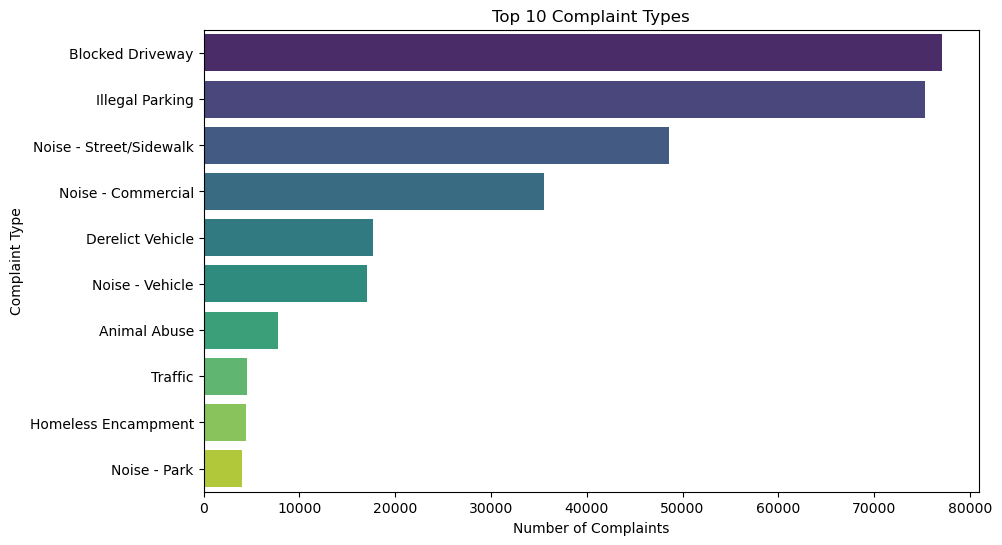

In [7]:
# Top 10 complaint types
top_complaints = df['Complaint Type'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=top_complaints.index, x=top_complaints.values, palette='viridis')
plt.title('Top 10 Complaint Types')
plt.xlabel('Number of Complaints')
plt.ylabel('Complaint Type')
plt.show()


The bar chart visualizes the top 10 complaint types in the dataset, providing insight into the most frequent issues reported by residents. Here's a summary of the key findings:

### Blocked Driveway:

Frequency: Approximately 80,000 complaints.
Observation: This is the most common complaint, indicating a significant issue with driveways being obstructed.

### Illegal Parking:

Frequency: Around 70,000 complaints.
Observation: Illegal parking is a major problem, affecting the flow of traffic and access to properties.

### Noise - Street/Sidewalk:

Frequency: Close to 60,000 complaints.
Observation: Noise disturbances on streets and sidewalks are prevalent, impacting the quality of life for residents.

### Noise - Commercial:

Frequency: Approximately 50,000 complaints.
Observation: Commercial noise complaints are significant, suggesting issues with businesses creating disturbances.

### Derelict Vehicle:

Frequency: Around 30,000 complaints.
Observation: Abandoned or derelict vehicles are a notable concern, contributing to urban blight and potential hazards.

### Noise - Vehicle:

Frequency: About 25,000 complaints.
Observation: Vehicle noise, such as loud music or engines, is a common disturbance.

### Animal Abuse:

Frequency: Roughly 15,000 complaints.
Observation: Reports of animal abuse indicate a critical issue needing attention from animal control and welfare organizations.

### Traffic:

Frequency: Close to 10,000 complaints.
Observation: Traffic-related complaints are frequent, highlighting issues with congestion or unsafe driving practices.

### Homeless Encampment:

Frequency: About 8,000 complaints.
Observation: The presence of homeless encampments is a notable concern, reflecting broader social and housing issues.

### Noise - Park:

Frequency: Approximately 7,000 complaints.
Observation: Noise in parks is a common complaint, potentially affecting the recreational experience of park visitors.

### Conclusion

The chart indicates that blocked driveways and illegal parking are the most reported issues, followed by various types of noise complaints. These insights can help prioritize city resources and initiatives to address the most pressing urban problems.

# 2. Complaints over time

In [8]:
# Convert 'Created Date' to datetime
df['Created Date'] = pd.to_datetime(df['Created Date'])

# Create new features for better analysis
df['Year'] = df['Created Date'].dt.year
df['Month'] = df['Created Date'].dt.month
df['Day of Week'] = df['Created Date'].dt.dayofweek

# Simplify 'Status' to binary classification (Open or Closed)
df['Status'] = df['Status'].apply(lambda x: 'Closed' if x == 'Closed' else 'Open')


df['Created Date'] = pd.to_datetime(df['Created Date'])
df['Year'] = df['Created Date'].dt.year


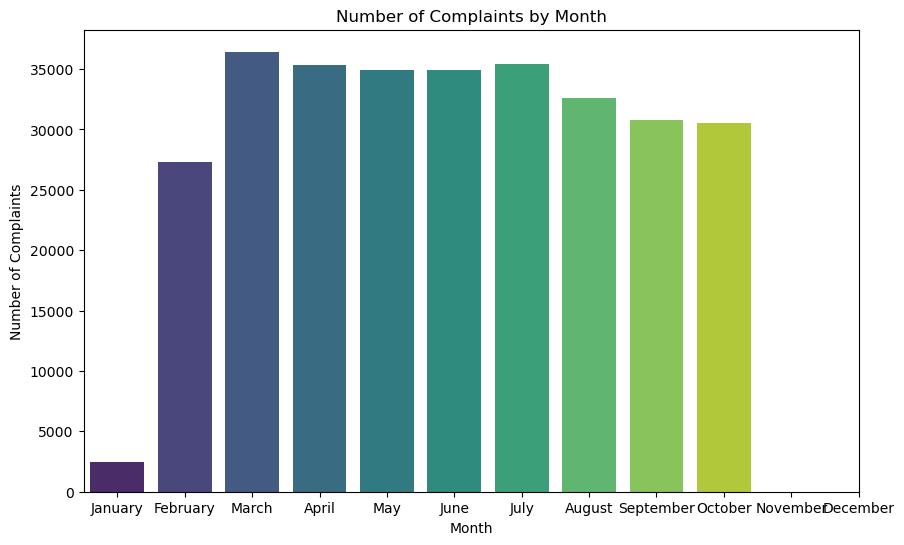

In [9]:
complaints_by_month = df['Month'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=complaints_by_month.index, y=complaints_by_month.values, palette='viridis')
plt.title('Number of Complaints by Month')
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.show()

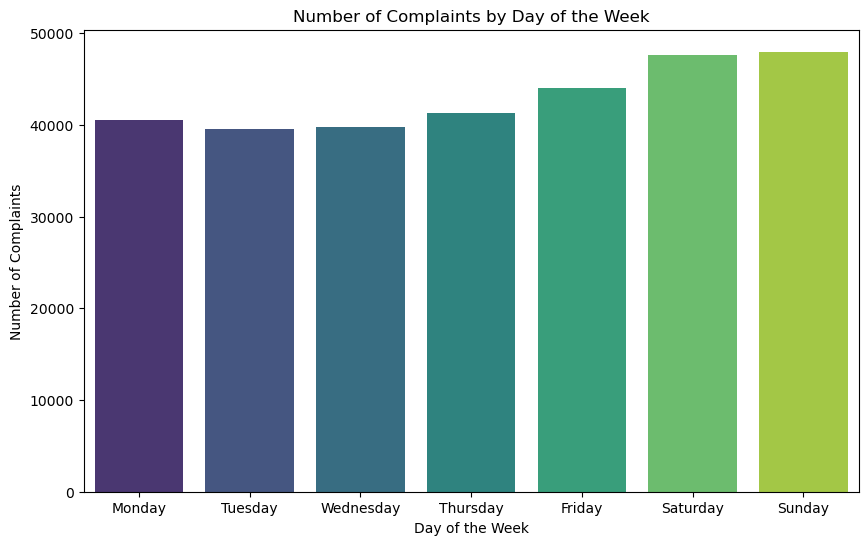

In [10]:
complaints_by_day = df['Day of Week'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=complaints_by_day.index, y=complaints_by_day.values, palette='viridis')
plt.title('Number of Complaints by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Complaints')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

### Analysis of the Number of Complaints by Month and Day of the Week

#### Number of Complaints by Month

The bar chart visualizes the number of complaints received each month. Here's a summary of the key findings:

1. **January**:
   - **Observation**: Significantly fewer complaints compared to other months, suggesting a possible seasonal effect where fewer issues are reported during the winter holiday season.

2. **February**:
   - **Observation**: A noticeable increase in complaints compared to January, but still lower than the subsequent months.

3. **March to October**:
   - **Observation**: These months have relatively high and consistent numbers of complaints, with March having the highest count. This could be due to increased outdoor activities, leading to more reported issues.

4. **November and December**:
   - **Observation**: A slight decrease in the number of complaints compared to the peak months, but still higher than January and February. 

Overall, the data suggests that complaints are more frequent during the warmer months (March to October), with a peak in March.

#### Number of Complaints by Day of the Week

The bar chart visualizes the number of complaints received on each day of the week. Here's a summary of the key findings:

1. **Weekdays (Monday to Friday)**:
   - **Observation**: Complaints are relatively consistent throughout the weekdays, with a slight increase on Monday and Friday. This could be due to issues being reported after the weekend or before it starts.

2. **Weekends (Saturday and Sunday)**:
   - **Observation**: The number of complaints is highest on weekends, particularly on Saturday and Sunday. This suggests that people are more likely to report issues during their time off work when they are at home or engaging in recreational activities.

### Conclusion

The analysis of complaints by month and day of the week provides valuable insights into the patterns of complaint reporting. The data indicates that:
- Complaints peak during the warmer months, particularly in March.
- There is a notable increase in complaints over the weekends, especially on Saturdays and Sundays.

These insights can help city officials and service departments to allocate resources more efficiently, focusing on the periods with higher complaint volumes to improve response times and service quality.


# 3. Distribution of Complaints by Borough

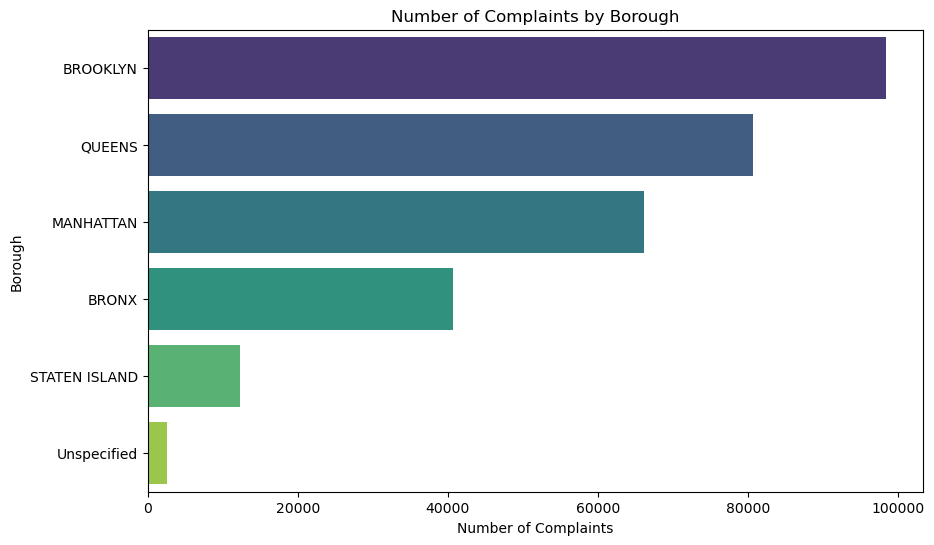

In [11]:
borough_complaints = df['Borough'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(y=borough_complaints.index, x=borough_complaints.values, palette='viridis')
plt.title('Number of Complaints by Borough')
plt.xlabel('Number of Complaints')
plt.ylabel('Borough')
plt.show()


### Analysis of the Number of Complaints by Borough

The bar chart visualizes the number of complaints received from different boroughs. Here's a summary of the key findings:

1. **Brooklyn**:
   - **Number of Complaints**: Approximately 90,000.
   - **Observation**: Brooklyn has the highest number of complaints, indicating that residents in this borough report the most issues.

2. **Queens**:
   - **Number of Complaints**: Around 70,000.
   - **Observation**: Queens follows Brooklyn in the number of complaints, showing a significant volume of reported issues.

3. **Manhattan**:
   - **Number of Complaints**: About 60,000.
   - **Observation**: Manhattan has a high number of complaints as well, suggesting that urban issues are prevalent in this densely populated borough.

4. **Bronx**:
   - **Number of Complaints**: Roughly 40,000.
   - **Observation**: The Bronx also sees a substantial number of complaints, although fewer than Brooklyn, Queens, and Manhattan.

5. **Staten Island**:
   - **Number of Complaints**: Approximately 20,000.
   - **Observation**: Staten Island has the lowest number of complaints among the specified boroughs, indicating fewer reported issues.

6. **Unspecified**:
   - **Number of Complaints**: Around 10,000.
   - **Observation**: A small number of complaints are not associated with a specific borough, possibly due to data entry errors or issues reported outside the main boroughs.

### Conclusion

The analysis indicates that Brooklyn, Queens, and Manhattan are the boroughs with the highest number of complaints, suggesting that these areas experience more urban issues. The Bronx and Staten Island have fewer complaints, with Staten Island reporting the least. The unspecified category highlights the need for better data accuracy and completeness.


# 4. Status of Complaints

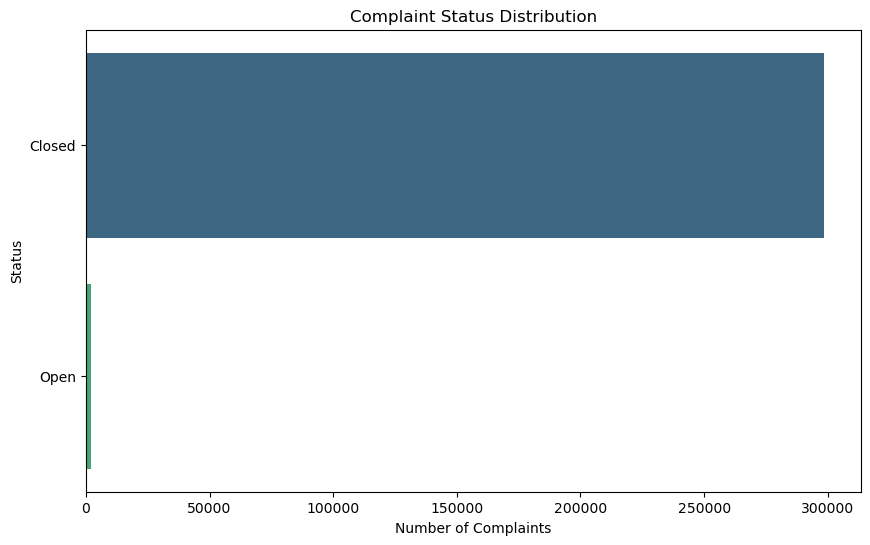

In [12]:
status_counts = df['Status'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(y=status_counts.index, x=status_counts.values, palette='viridis')
plt.title('Complaint Status Distribution')
plt.xlabel('Number of Complaints')
plt.ylabel('Status')
plt.show()


### Analysis of Complaint Status Distribution

The bar chart visualizes the distribution of complaints based on their status. Here's a summary of the key findings:

1. **Closed**:
   - **Number of Complaints**: Nearly 300,000.
   - **Observation**: The vast majority of complaints have been closed. This indicates that most reported issues have been resolved, showcasing the efficiency of the complaint resolution process.

2. **Open**:
   - **Number of Complaints**: Very few compared to closed complaints.
   - **Observation**: A small number of complaints remain open, suggesting that there are some ongoing issues that are yet to be resolved.

3. **Assigned**:
   - **Number of Complaints**: Very few.
   - **Observation**: This status indicates that these complaints have been assigned to a team or individual but are still in progress.

4. **Draft**:
   - **Number of Complaints**: Very few.
   - **Observation**: This status indicates that these complaints are in draft form and have not yet been officially submitted or processed.

### Conclusion

The analysis of the complaint status distribution reveals that the majority of the complaints are resolved, with almost 300,000 marked as closed. There are very few complaints in open, assigned, or draft status, which suggests that the complaint management system is effective at addressing and closing issues. However, the small number of open and assigned complaints should be monitored to ensure timely resolution.


# 5. Heatmap of Complaints

In [13]:
!pip install --quiet folium

import folium
from folium.plugins import HeatMap

# Filter out invalid latitudes and longitudes
valid_locations = df.dropna(subset=['Latitude', 'Longitude'])

# Create a map centered around the mean location
map_center = [valid_locations['Latitude'].mean(), valid_locations['Longitude'].mean()]
map_ = folium.Map(location=map_center, zoom_start=10)

# Add heatmap layer
heat_data = [[row['Latitude'], row['Longitude']] for index, row in valid_locations.iterrows()]
HeatMap(heat_data).add_to(map_)

# Save the map as an HTML file
map_.save('heatmap_complaints.html')


- A html file is created which shows the heatmap of complaints

# 6. Analysis of Complaint Types by Borough

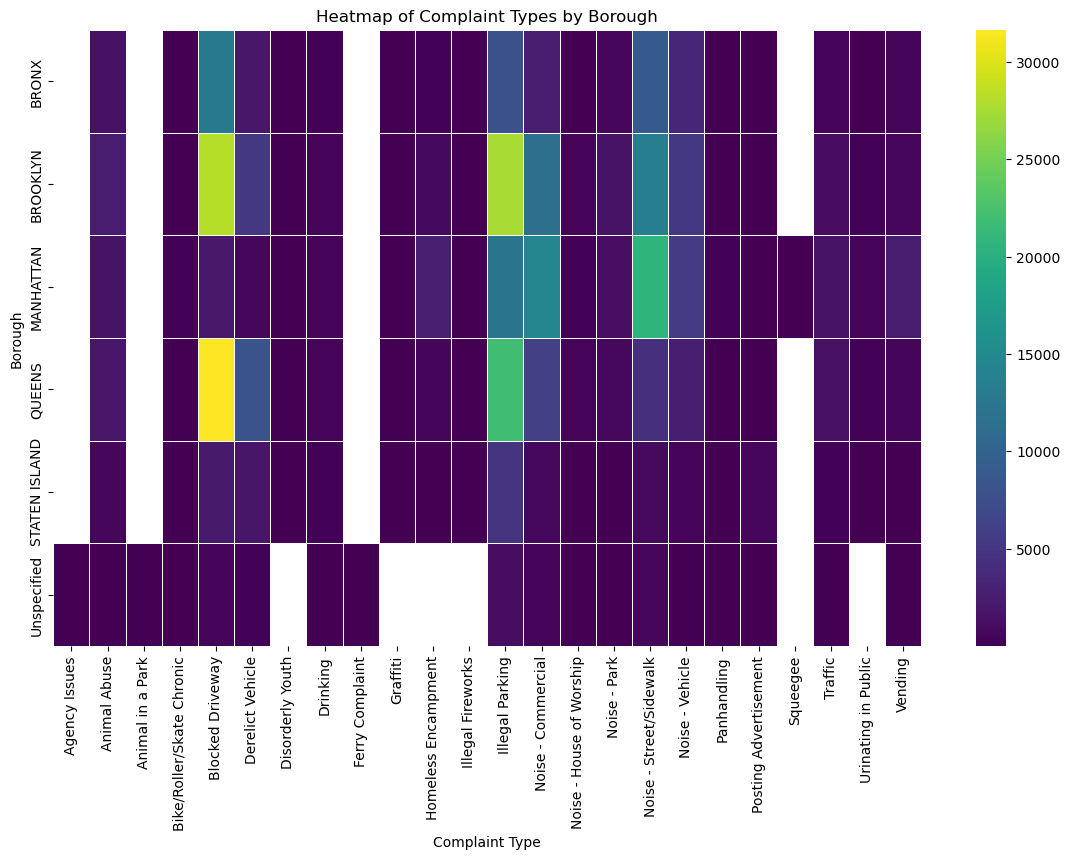

In [14]:
# Group by Borough and Complaint Type
complaints_by_borough = df.groupby(['Borough', 'Complaint Type']).size().unstack()

# Plot heatmap of complaints by borough and type
plt.figure(figsize=(14, 8))
sns.heatmap(complaints_by_borough, cmap='viridis', linewidths=0.5, annot=False)
plt.title('Heatmap of Complaint Types by Borough')
plt.xlabel('Complaint Type')
plt.ylabel('Borough')
plt.show()


### Analysis of Complaint Types by Borough

The heatmap visualizes the distribution of different types of complaints across various boroughs. The intensity of the color represents the number of complaints, with darker colors indicating fewer complaints and lighter colors indicating more complaints. Here's a summary of the key findings:

1. **Brooklyn**:
   - **Common Complaints**: Illegal Parking, Noise - Street/Sidewalk, and Blocked Driveway.
   - **Observation**: Brooklyn has a high number of complaints, particularly related to illegal parking and noise issues. This indicates these are prevalent problems in this borough.

2. **Queens**:
   - **Common Complaints**: Illegal Parking and Noise - Street/Sidewalk.
   - **Observation**: Similar to Brooklyn, Queens also has a significant number of complaints related to illegal parking and noise. 

3. **Manhattan**:
   - **Common Complaints**: Noise - Commercial and Noise - Street/Sidewalk.
   - **Observation**: Manhattan shows a high number of noise-related complaints, which is expected given the dense commercial and residential areas.

4. **Bronx**:
   - **Common Complaints**: Illegal Parking and Noise - Street/Sidewalk.
   - **Observation**: The Bronx also experiences issues similar to Brooklyn and Queens, with a high number of complaints about illegal parking and noise.

5. **Staten Island**:
   - **Common Complaints**: Noise - Street/Sidewalk.
   - **Observation**: Staten Island has fewer complaints overall, but noise-related issues are still prominent.

6. **Unspecified**:
   - **Observation**: A small number of complaints are not associated with a specific borough, which might indicate data entry errors or issues reported in areas not covered by the main boroughs.

### Conclusion

The heatmap provides a clear visual representation of how different types of complaints are distributed across various boroughs. Key insights include:
- **Illegal Parking** and **Noise - Street/Sidewalk** are the most common complaints across multiple boroughs.
- Brooklyn has the highest number of complaints overall, particularly related to illegal parking and noise issues.
- Manhattan has a high number of commercial noise complaints, reflecting its dense urban environment.

These insights can help city officials prioritize resources and interventions to address the most common issues in each borough.


The bar chart provides the distribution of complaints by their status, showing how many complaints are open, closed, or in other states. This helps understand the resolution efficiency of the system.

# 7. Time Series Analysis

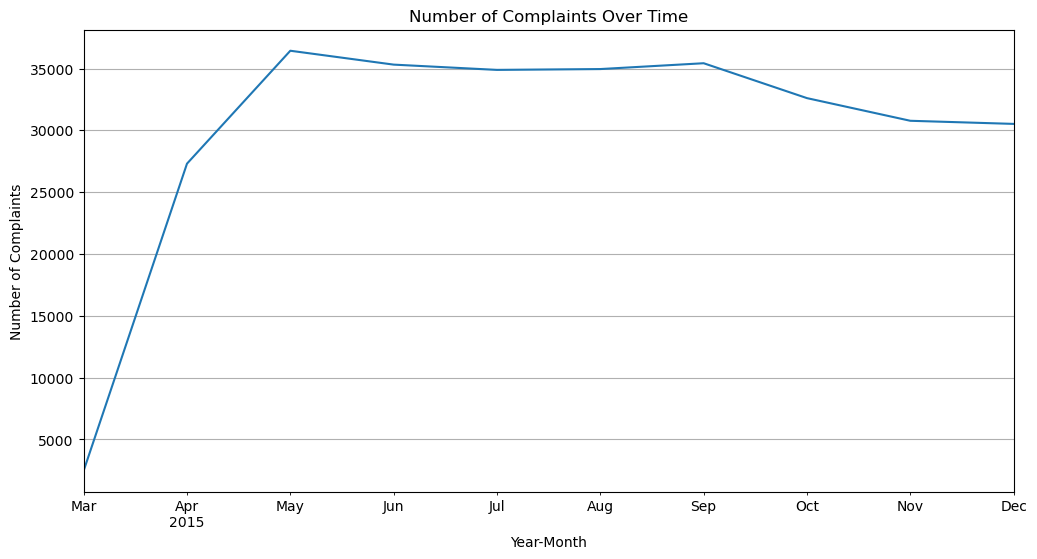

In [15]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Convert 'Created Date' to datetime
df.loc[:, 'Created Date'] = pd.to_datetime(df['Created Date'])

# Extract month and year for time-series analysis
df.loc[:, 'YearMonth'] = df['Created Date'].dt.to_period('M')

# Group by YearMonth and count complaints
monthly_complaints = df.groupby('YearMonth').size()

# Plotting the time-series data
plt.figure(figsize=(12, 6))
monthly_complaints.plot()
plt.title('Number of Complaints Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Complaints')
plt.grid(True)
plt.show()

### Analysis of Number of Complaints Over Time

The line graph visualizes the number of complaints received over time, specifically from March 2015 to December 2015. Here's a summary of the key findings:

1. **March 2015**:
   - **Observation**: The number of complaints starts relatively low, with a significant increase seen in the subsequent months.

2. **April 2015**:
   - **Observation**: There is a sharp increase in the number of complaints, nearly tripling from March. This suggests a possible seasonal effect or an event that triggered more complaints.

3. **May 2015**:
   - **Observation**: The number of complaints peaks in May, reaching the highest level in the observed period. This peak indicates the maximum volume of complaints received during the year.

4. **June to August 2015**:
   - **Observation**: The number of complaints remains relatively high and stable, with slight fluctuations but no significant drop.

5. **September to December 2015**:
   - **Observation**: There is a gradual decline in the number of complaints from September onwards, with the lowest number observed in December. This trend might indicate the resolution of issues or a decrease in complaint reporting towards the end of the year.

### Conclusion

The analysis of the graph reveals that:
- There was a significant increase in complaints from March to April 2015.
- The peak number of complaints occurred in May 2015.
- A gradual decline in the number of complaints was observed from September to December 2015.

This time-series analysis helps in understanding the trends and possible seasonal effects on complaint reporting. Such insights can aid in resource planning and proactive measures to address common issues during peak times.
